In [1]:
import os
import glob
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import rasterio
from rasterio.plot import reshape_as_image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#tf.debugging.set_log_device_placement(True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')


2023-09-22 09:20:35.796314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 09:20:36.290424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Constants

TEST_SIZE = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 500
INPUT_SHAPE = (256, 256, 12) # 12 bands for input images
LABEL_SHAPE = (256, 256, 1)

FILTERS = 32
N_CLASSES = 9
EPOCHS = 60


IMAGE_DIRECTORY = images_path = os.path.join(os.getcwd(), "data", "images")
LABEL_DIRECTORY = images_path = os.path.join(os.getcwd(), "data", "labels")

In [3]:
def create_file_paths_labels(img_directory: str, lbl_directory: str):
    img_paths = sorted(glob.glob(img_directory + '/*.tif'))
    label_paths = sorted(glob.glob(lbl_directory + '/*.tif'))
    return img_paths, label_paths


image_paths, label_paths = create_file_paths_labels(IMAGE_DIRECTORY, LABEL_DIRECTORY)
number_of_images, number_of_masks = len(image_paths), len(label_paths)

print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[55]}")
print(f"3. An example of a mask path is: \n {label_paths[55]}")

1. There are 1920 images and 1920 masks in our dataset
2. An example of an image path is: 
 /home/stolarinho/Desktop/test2/git2/data/images/000000000055.tif
3. An example of a mask path is: 
 /home/stolarinho/Desktop/test2/git2/data/labels/000000000055.tif


Displaying 699th image and label
# # # Image # # #
Shape:
width:256, height:256, depth: 12
CRS: EPSG:32633


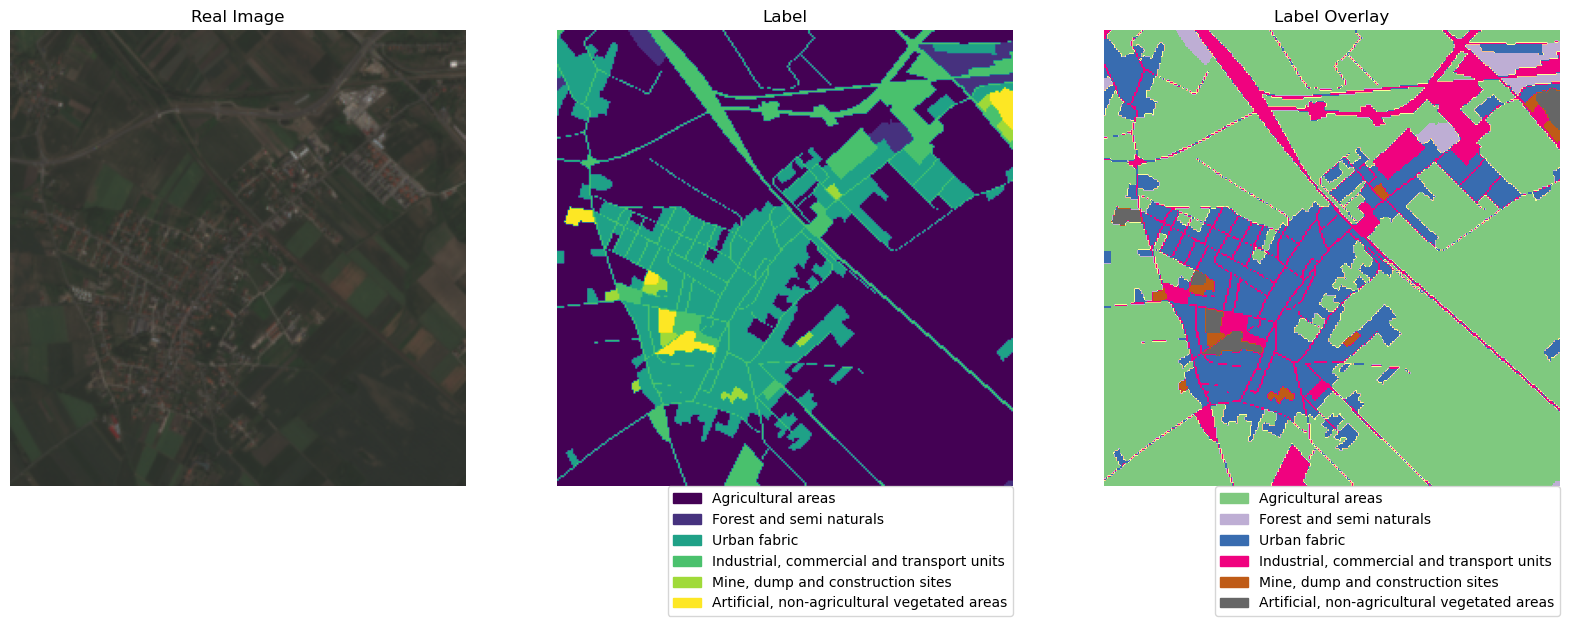

In [4]:
# Preview random masked and unmasked images by reading them from their paths

LABELS = {
            0 : "NO DATA",
            1: "Agricultural areas",
            2: "Forest and semi naturals",
            3: "Wetlands",
            4: "Water bodies",
            5: "Urban fabric",
            6: "Industrial, commercial and transport units",
            7: "Mine, dump and construction sites",
            8: "Artificial, non-agricultural vegetated areas"
        }

number_images_to_plot = 1
number_of_samples = len(image_paths)

def s2_image_to_rgb(image):
    result_array = np.array([image.read(4), image.read(3), image.read(2)], dtype=float)
    result_array = np.transpose(result_array, (1, 2, 0))
    
    result_array = (result_array / 10000) + 0.15 # 0.15 added to brighten up the image        
    
    return result_array

def get_unique_values(image):
    return np.unique(image) 

def get_cmap_colors(im, image):
    return im.cmap(im.norm(np.unique(image)))

def get_cmap(values, colors):
    result = None
    if len(values) == len(colors):
        result = {values[i]: colors[i] for i in range(len(values))}
    return result

def get_patches(im, image):
    unique_values = get_unique_values(image)
    cmap_colors = get_cmap_colors(im, image)
    cmap = get_cmap(unique_values, cmap_colors)
    labels = LABELS
    return [mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]

def print_image_metadata(title ,image):
    print(f"# # # {title} # # #")
    print(f"Shape:\nwidth:{image.width}, height:{image.height}, depth: {image.count}")
    print(f"CRS: {image.crs}")

for i in range(number_images_to_plot):
    B = random.randint(0, number_of_samples - 1)
    print(f"Displaying {B}th image and label")

    image_path = image_paths[B]
    label_path = label_paths[B]

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))

    with rasterio.open(image_path) as image, rasterio.open(label_path) as label:
        print_image_metadata("Image", image)
        #print_image_metadata("Label", label)

        image_rgb = s2_image_to_rgb(image)
        label = label.read(1)     
                          
            
        arr[0].imshow(X=image_rgb)
        arr[0].set_title('Real Image')
        arr[0].axis("off")
        
        
        im1 = arr[1].imshow(label)
        arr[1].set_title('Label')
        arr[1].axis("off")
        patches1 = get_patches(im1, label)
        arr[1].legend(handles=patches1, bbox_to_anchor=(1.0, 0), loc=0, borderaxespad=0.)
        
                          
        im2 = arr[2].imshow(label, cmap='Accent') # another fine cmap 'Paired'
        arr[2].set_title('Label Overlay')
        arr[2].axis("off")        
        patches2 = get_patches(im2, label)
        arr[2].legend(handles=patches2, bbox_to_anchor=(1.0, 0), loc=0, borderaxespad=0.)
        

        
        
        
        

In [5]:
### Split the image and mask paths into training, validation, and test sets

# First split the image paths into training and validation sets
train_img_paths, test_img_paths, train_label_paths, test_label_paths = train_test_split(image_paths, label_paths, train_size = TEST_SIZE, random_state=0)

# Keep part of the validation set as test set
val_img_paths, test_img_paths, val_label_paths, test_label_paths = train_test_split(test_img_paths, test_label_paths, train_size = TEST_SIZE, random_state=0)


print(f'There are {len(train_img_paths)} images in the Training Set')
print(f'There are {len(val_img_paths)} images in the Validation Set')
print(f'There are {len(test_img_paths)} images in the Test Set')

There are 1728 images in the Training Set
There are 172 images in the Validation Set
There are 20 images in the Test Set


In [6]:
# Create TensorFlow datasets from given image and label paths
def create_tf_datasets(img_paths, lbl_paths):    
    image_tf_list = tf.constant(img_paths)
    label_tf_list = tf.constant(lbl_paths)    
    return tf.data.Dataset.from_tensor_slices((image_tf_list, label_tf_list))
     

    # Load and preprocess an image-label pair given their paths
def load_and_preprocess(img_path, label_path):
    with rasterio.open(img_path.numpy().decode(), 'r') as img_src, rasterio.open(label_path.numpy().decode(), 'r') as lbl_src:
        img = img_src.read()
        img = reshape_as_image(img)        
        img = tf.image.convert_image_dtype(img, tf.float32)


        lbl = lbl_src.read()
        lbl = reshape_as_image(lbl)
        lbl = tf.math.reduce_max(lbl, axis=-1, keepdims=True)
        lbl = tf.cast(lbl, tf.uint16) 
        

        
    return img, lbl

# Wrapper function for using 'load_and_preprocess' with TensorFlow operations
def load_and_preprocess_wrapper(img_path, label_path):
    img, lbl = tf.py_function(func=load_and_preprocess, inp=[img_path, label_path], Tout=(tf.float32, tf.uint16))
    img.set_shape(INPUT_SHAPE)
    lbl.set_shape(LABEL_SHAPE)
    return img, lbl

# Preprocess and batch the training, testing, and validation datasets
def preprocess_datasets(train_dataset, test_dataset, val_dataset, buffer_size, batch_size):
    train_dataset = train_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    train_dataset = train_dataset.batch(batch_size)
    test_dataset = test_dataset.batch(batch_size)
    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, test_dataset, val_dataset

In [7]:
# Prepate datasets
train_dataset = create_tf_datasets(train_img_paths, train_label_paths)
test_dataset = create_tf_datasets(test_img_paths, test_label_paths)
val_dataset = create_tf_datasets(val_img_paths, val_label_paths)



train_dataset, test_dataset, val_dataset = preprocess_datasets(train_dataset, test_dataset, val_dataset, BUFFER_SIZE, BATCH_SIZE)


2023-09-22 09:20:38.349058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 09:20:38.362925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 09:20:38.363132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
# Convolutional downsampling block
def encoding_block(inputs, filters, max_pooling=True):
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(inputs)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)

    skip_connection = C

    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(C)
    else:
        next_layer = C
    return next_layer, skip_connection

# Convolutional upsampling block
def decoding_block(inputs, skip_connection_input, filters):
    CT = Conv2DTranspose(filters, 3, strides=(2,2), padding="same", kernel_initializer="he_normal")(inputs)
    residual_connection = concatenate([CT, skip_connection_input], axis=3)
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(residual_connection)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    C = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(C)
    C = BatchNormalization()(C)
    C = Activation("relu")(C)
    return C

# Build the U-Net model: Consists of encoding blocks followed by a bottleneck and then decoding blocks
def unet_model(input_size, filters, n_classes):
    inputs = Input(input_size)

    C1, S1 = encoding_block(inputs, filters, max_pooling=True)
    C2, S2 = encoding_block(C1, filters * 2, max_pooling=True)
    C3, S3 = encoding_block(C2, filters * 4, max_pooling=True)
    C4, S4 = encoding_block(C3, filters * 8, max_pooling=True)
    C5, S5 = encoding_block(C4, filters * 16, max_pooling=False)

    U6 = decoding_block(C5, S4, filters * 8)
    U7 = decoding_block(U6, S3,  filters * 4)
    U8 = decoding_block(U7, S2,  filters * 2)
    U9 = decoding_block(U8, S1,  filters)

    C10 = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(U9)
    C11 = Conv2D(filters=n_classes, kernel_size = (1,1), activation='softmax',  padding='same')(C10)
    model = Model(inputs=inputs, outputs=C11)
    return model


model = unet_model(INPUT_SHAPE, filters=FILTERS, n_classes=N_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                2)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  3488        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 512)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 512)  2359808     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 16, 16, 512)  2048       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 512)  0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_tr

 batch_normalization_16 (BatchN  (None, 256, 256, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 256, 256, 32  0           ['batch_normalization_16[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 32  9248        ['activation_16[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 256, 256, 32  128        ['conv2d_17[0][0]']              
 ormalizat

In [9]:
# Masked sparse categorical cross-entropy loss function.
# This function calculates the loss only for labeled pixels in the ground truth.
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    
    # Create a mask for y_true where labeled pixels are set to True
    mask = tf.math.greater(y_true, 0)
    mask_squeezed = tf.squeeze(mask, axis=-1)

    # Apply the mask to both ground truth and predictions
    y_true_masked = tf.boolean_mask(y_true, mask_squeezed)
    y_preds_list = [tf.boolean_mask(y_pred[..., i], mask_squeezed) for i in range(y_pred.shape[-1])]
    y_pred_masked = tf.stack(y_preds_list, axis=-1)
    
    # Calculate the loss using sparse categorical cross-entropy.
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred_masked)
    
    return tf.reduce_mean(loss)

In [10]:
model.compile(optimizer = 'adam', loss=masked_sparse_categorical_crossentropy, metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)


history = model.fit(train_dataset, 
            validation_data = val_dataset, 
            epochs = EPOCHS, 
            verbose=1, 
            callbacks = [callback, reduce_lr], 
            shuffle = True)


Epoch 1/60


2023-09-22 09:20:39.396313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1728]
	 [[{{node Placeholder/_1}}]]
2023-09-22 09:20:43.848552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-22 09:20:44.221818: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 09:20:47.010364: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-09-22 09:20:47.010406: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_

54/54 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.6297

2023-09-22 09:21:44.811312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [172]
	 [[{{node Placeholder/_1}}]]


54/54 [==============================] - 72s 997ms/step - loss: 0.7277 - accuracy: 0.6297 - val_loss: 2.2008 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 2/60
54/54 [==============================] - 53s 972ms/step - loss: 0.4013 - accuracy: 0.6990 - val_loss: 2.3383 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 3/60
54/54 [==============================] - 53s 974ms/step - loss: 0.3637 - accuracy: 0.7061 - val_loss: 2.3531 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 4/60
54/54 [==============================] - 53s 974ms/step - loss: 0.3412 - accuracy: 0.7099 - val_loss: 2.3578 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 5/60
54/54 [==============================] - 53s 973ms/step - loss: 0.3213 - accuracy: 0.7148 - val_loss: 2.5935 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 6/60
54/54 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.7177
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
54/54 [==============================] - 53s 975ms/step - lo

54/54 [==============================] - 54s 982ms/step - loss: 0.1871 - accuracy: 0.7476 - val_loss: 0.1954 - val_accuracy: 0.7587 - lr: 1.0000e-05
Epoch 51/60
54/54 [==============================] - 53s 971ms/step - loss: 0.1866 - accuracy: 0.7477 - val_loss: 0.1950 - val_accuracy: 0.7589 - lr: 1.0000e-05
Epoch 52/60
54/54 [==============================] - 54s 997ms/step - loss: 0.1862 - accuracy: 0.7478 - val_loss: 0.1946 - val_accuracy: 0.7590 - lr: 1.0000e-05
Epoch 53/60
54/54 [==============================] - 54s 990ms/step - loss: 0.1857 - accuracy: 0.7480 - val_loss: 0.1943 - val_accuracy: 0.7591 - lr: 1.0000e-05
Epoch 54/60
54/54 [==============================] - 53s 971ms/step - loss: 0.1852 - accuracy: 0.7481 - val_loss: 0.1940 - val_accuracy: 0.7591 - lr: 1.0000e-05
Epoch 55/60
54/54 [==============================] - 53s 971ms/step - loss: 0.1848 - accuracy: 0.7482 - val_loss: 0.1935 - val_accuracy: 0.7593 - lr: 1.0000e-05
Epoch 56/60
54/54 [===========================

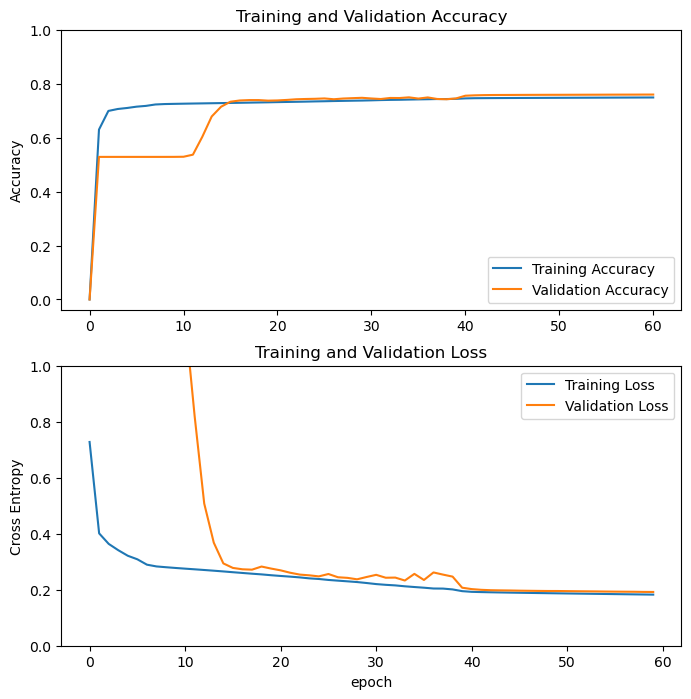

In [11]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
model.save('unet_model.h5')

In [13]:
# Compute Model Accuracy
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = BATCH_SIZE)
validation_loss, validation_accuracy = model.evaluate(val_dataset, batch_size = BATCH_SIZE)

print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

54/54 [==============================] - 38s 693ms/step - loss: 0.1820 - accuracy: 0.7487


2023-09-22 10:14:50.787567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [20]
	 [[{{node Placeholder/_1}}]]


6/6 [==============================] - 4s 551ms/step - loss: 0.1920 - accuracy: 0.7597
Model Accuracy on the Training Dataset: 74.87%
Model Accuracy on the Validation Dataset: 75.97%
Model Accuracy on the Test Dataset: 63.28%


2023-09-22 10:14:57.932297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [172]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 260ms/step


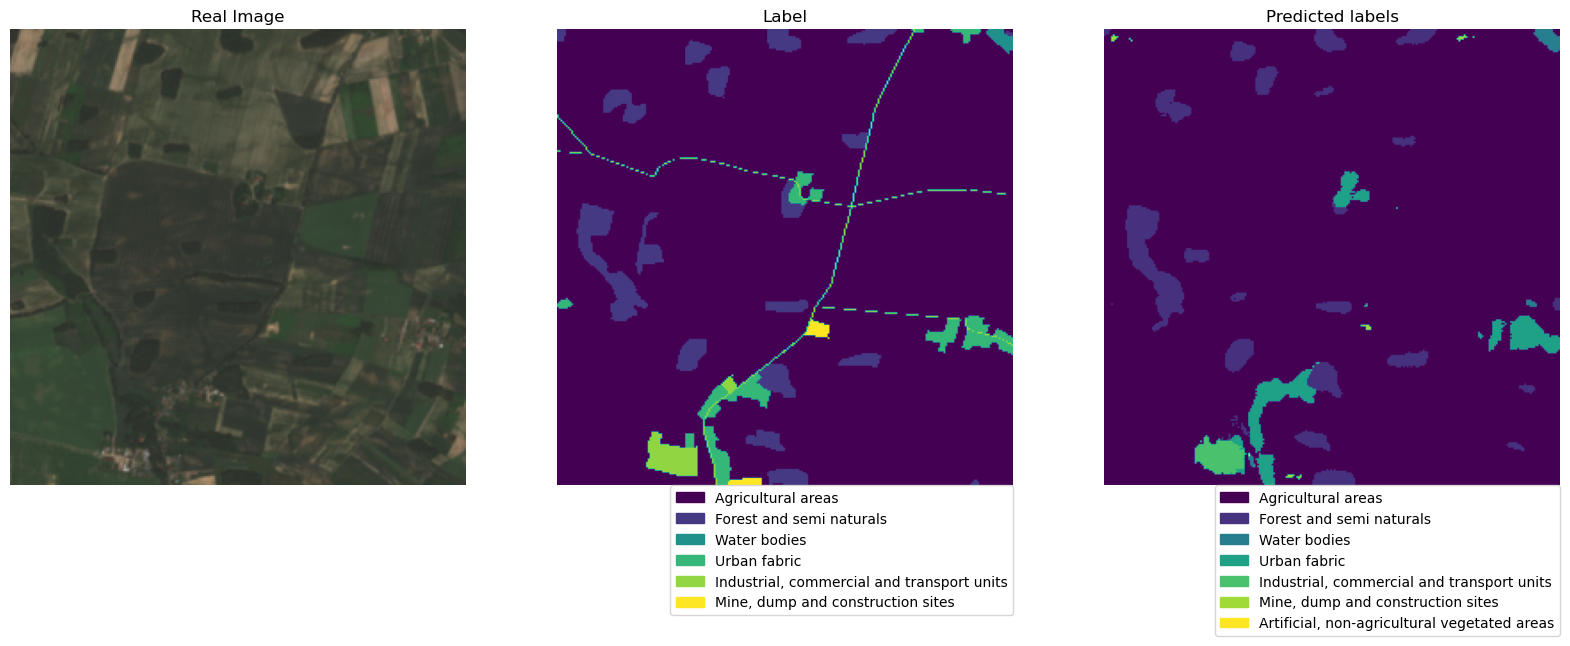

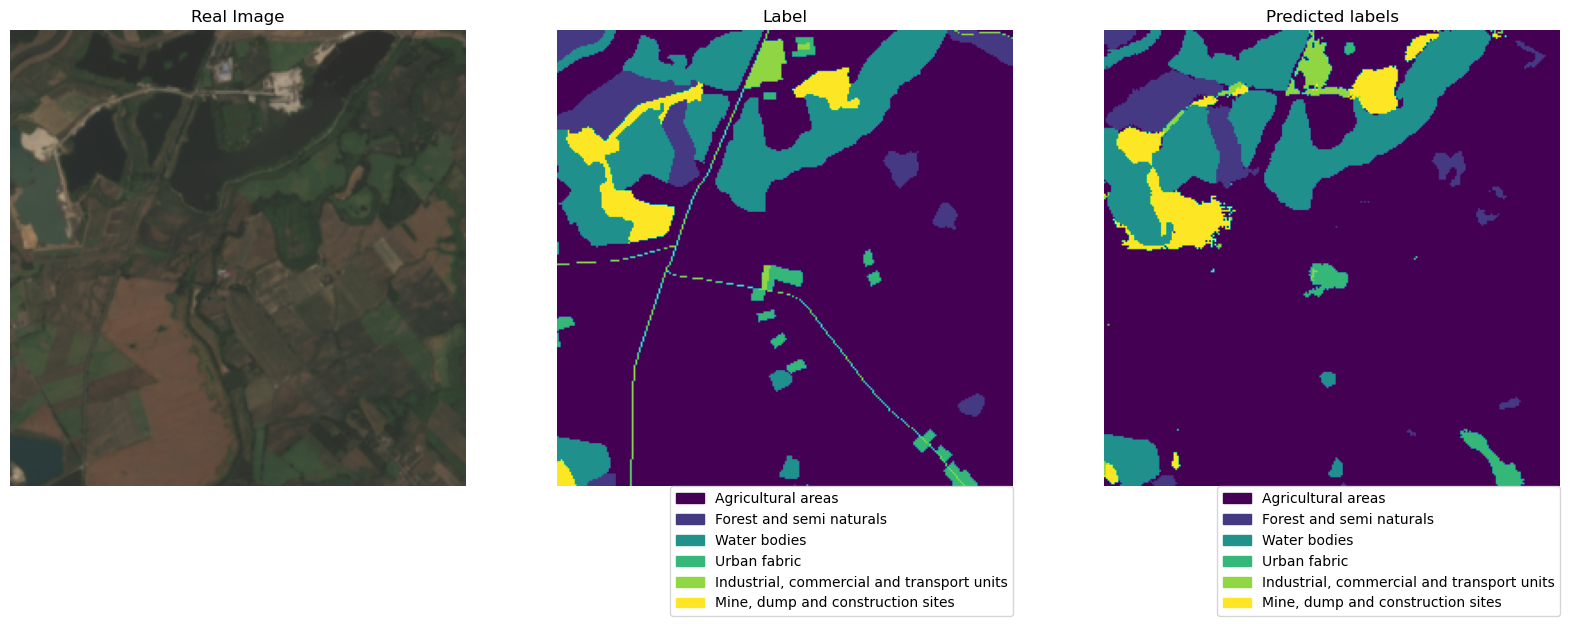

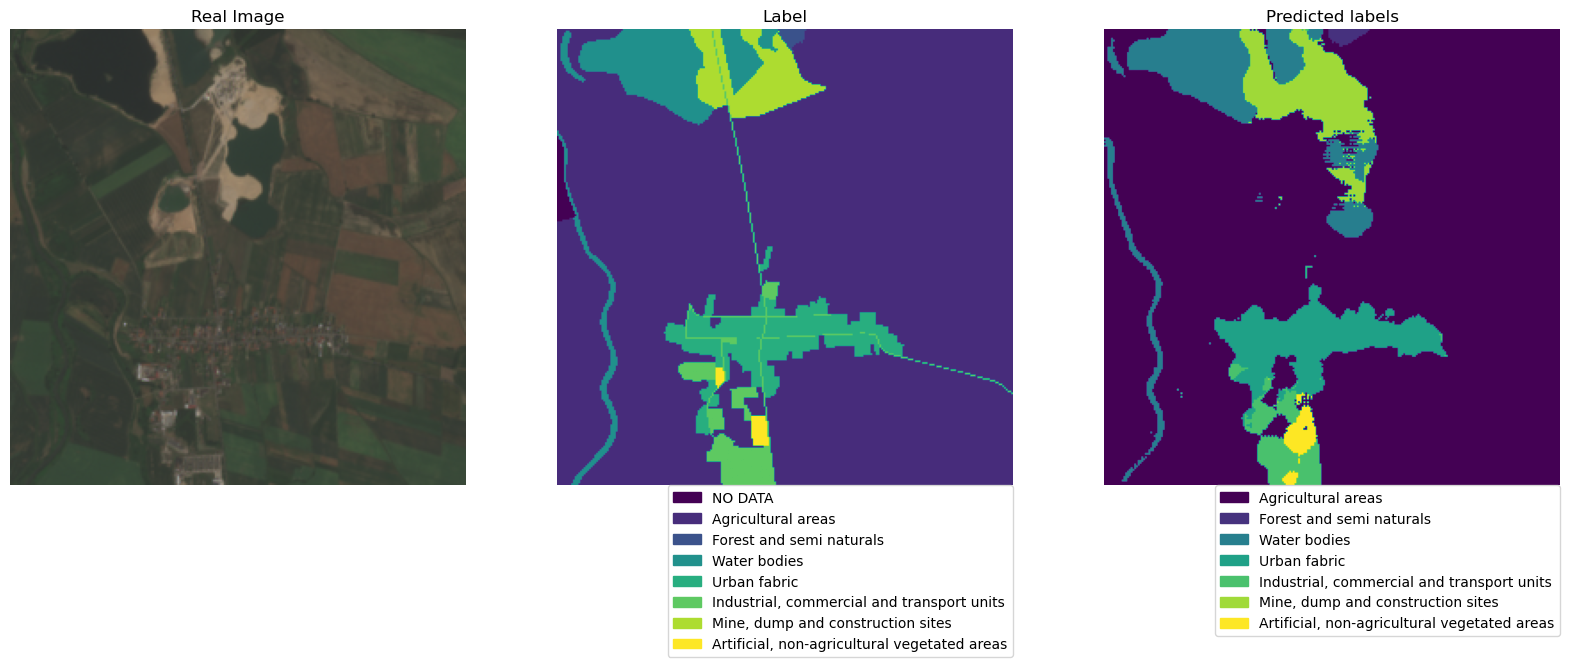

In [14]:
# Evaluate model

number_of_batches = 1
number_of_images = 3
    

for image, label in val_dataset.take(number_of_batches):        
    predictions = model.predict(image)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    for i in range(number_of_images):
        
        fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    
        image_rgb = image[i][:,:,3:0:-1] * 10 + 0.15    
        arr[0].imshow(image_rgb)
        arr[0].set_title('Real Image')
        arr[0].axis("off")

        
        im1 = arr[1].imshow(label[i])
        arr[1].set_title('Label')
        arr[1].axis("off")
        ptch1 = get_patches(im1, label[i])
        arr[1].legend(handles=ptch1, bbox_to_anchor=(1.0, 0), loc=0, borderaxespad=0.)


        im2 = arr[2].imshow(predicted_classes[i])
        arr[2].set_title('Predicted labels')
        arr[2].axis("off")
        ptch2 = get_patches(im2, predicted_classes[i])
        arr[2].legend(handles=ptch2, bbox_to_anchor=(1.0, 0), loc=0, borderaxespad=0.)
    
        plt.show()
    